<a href="https://colab.research.google.com/github/georgezalokostas/Handwritten-To-Text-EMNIST/blob/main/Handwritten_to_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing the Dataset and Dependencies**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime, os
import cv2
import json

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import TensorBoard
from keras import backend
from difflib import get_close_matches
import imutils
%matplotlib inline

!pip install emnist
from emnist import list_datasets

!pip install sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(list_datasets())

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']


# **Pre-Processing the Data**

In [2]:
from emnist import extract_training_samples
(train_images, train_labels) = extract_training_samples('balanced')
print(train_images.shape)

from emnist import extract_test_samples
(test_images, test_labels) = extract_test_samples('balanced')
print(test_images.shape)

# Normalizing the values to 0-1
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255
test_images /= 255



#train_images = keras.utils.to_categorical(train_images)
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e',
               'f', 'g', 'h', 'n', 'q', 'r', 't']

X_train = train_images
X_train=X_train.reshape(X_train.shape[0],28,28,1)
X_test=test_images
X_test=X_test.reshape(X_test.shape[0],28,28,1)

(112800, 28, 28)
(18800, 28, 28)


In [3]:
def segmented_image(image_path):

  image = cv2.imread(image_path)
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)

  #plt.imshow(image_blurred)
  #plt.show()

  # perform edge detection, find contours in the edge map using kernel size of 5,5
  edged_image = cv2.Canny(image_blurred, 30, 150)
  # detecting edges
  conts = cv2.findContours(edged_image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  # extracting contours of the image
  # now sorting contours from left to right
  def sort_contours(conts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # decision variable  if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
      reverse = True
    # sorting based on x and y coordinates
    if method == "top-to-bottom" or method == "bottom-to-top":
      i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in conts]
    (conts, boundingBoxes) = zip(*sorted(zip(conts, boundingBoxes),
      key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (conts, boundingBoxes)
  conts = sort_contours(conts, method="left-to-right")[0]
  # characters that we will be storing
  characters = []
  for i in conts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(i)
    # filter bounding boxes, ensuring they not very big and small 
    
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
      # extract the character and threshold it to make the character
      # it will appear as  white character on a black background 
      # access the width and height of the thresholded image
      roi = image_gray[y:y + h, x:x + w]
      thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      (tH, tW) = thresh.shape
      # if the width is greater than the height, resize along the
      # width dimension
      if tW > tH:
        thresh = imutils.resize(thresh, width=28)
      # otherwise, resize along the height
      else:
        thresh = imutils.resize(thresh, height=28)
          
    
      (tH, tW) = thresh.shape
      dX = int(max(0, 28 - tW) / 2.0)
      dY = int(max(0, 28 - tH) / 2.0)
    # padding for resizing if dimensions are low
      padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0))
      padded = cv2.resize(padded, (28, 28))
      # prepare the padded image for classification via our
      # handwriting OCR model
      padded = padded.astype("float32") / 255.0
      padded = np.expand_dims(padded, axis=-1)
      
      characters.append((padded, (x, y, w, h)))
  boxes = [b[1] for b in characters]
  characters = np.array([c[0] for c in characters], dtype="float32")
  return characters

# **Training The model**

In [5]:
image_shape=(28,28,1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=image_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(47, activation='softmax')])
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 flatten (Flatten)           (None, 800)               0

In [6]:
history=model.fit(X_train, train_labels,validation_data=(X_test,test_labels), epochs=40, batch_size=500,shuffle=True)

Epoch 1/40
226/226 [==============================] - 104s 457ms/step - loss: 1.8516 - accuracy: 0.4767 - val_loss: 0.7150 - val_accuracy: 0.7825
Epoch 2/40
226/226 [==============================] - 102s 449ms/step - loss: 0.9126 - accuracy: 0.7121 - val_loss: 0.5548 - val_accuracy: 0.8214
Epoch 3/40
226/226 [==============================] - 102s 452ms/step - loss: 0.7587 - accuracy: 0.7571 - val_loss: 0.4939 - val_accuracy: 0.8376
Epoch 4/40
226/226 [==============================] - 102s 450ms/step - loss: 0.6827 - accuracy: 0.7770 - val_loss: 0.4562 - val_accuracy: 0.8488
Epoch 5/40
226/226 [==============================] - 101s 448ms/step - loss: 0.6403 - accuracy: 0.7905 - val_loss: 0.4354 - val_accuracy: 0.8528
Epoch 6/40
226/226 [==============================] - 100s 443ms/step - loss: 0.6083 - accuracy: 0.7995 - val_loss: 0.4193 - val_accuracy: 0.8565
Epoch 7/40
226/226 [==============================] - 100s 442ms/step - loss: 0.5846 - accuracy: 0.8061 - val_loss: 0.4062 -

In [7]:
results = model.evaluate(X_test,test_labels)
print(results)
#%tensorboard --logdir logs

predictions = model.predict(X_test[:])

588/588 [==============================] - 5s 8ms/step - loss: 0.3271 - accuracy: 0.8823
[0.32705870270729065, 0.8822872042655945]


# **Graphs**

In [8]:
acc_tr = history.history['accuracy']
loss_tr = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = history.epoch

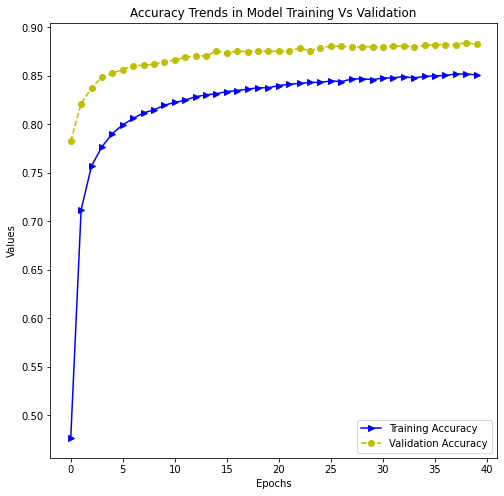

In [9]:
plt.figure(figsize=(8,8))
plt.title('Accuracy Trends in Model Training Vs Validation')
plt.plot(epochs,acc_tr,'b->',label='Training Accuracy')
plt.plot(epochs,val_acc,'y--o',label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

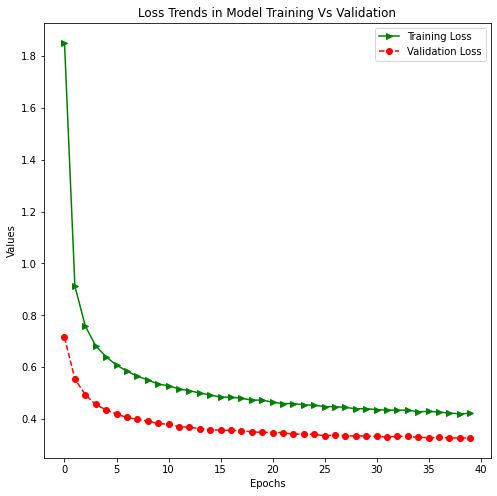

In [10]:
plt.figure(figsize=(8,8))
plt.title('Loss Trends in Model Training Vs Validation')
plt.plot(epochs,loss_tr,'g->',label='Training Loss')
plt.plot(epochs,val_loss,'r--o',label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

In [ ]:
#Needs changes in latest Tensorflow Version
'''
from sklearn.metrics import classification_report

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)
oh= sklearn.preprocessing.OneHotEncoder()

preds=oh.fit_transform(predictions.reshape(-1,1))
print(classification_report(predictions,test_labels))
'''

# **Confusion Matrix**

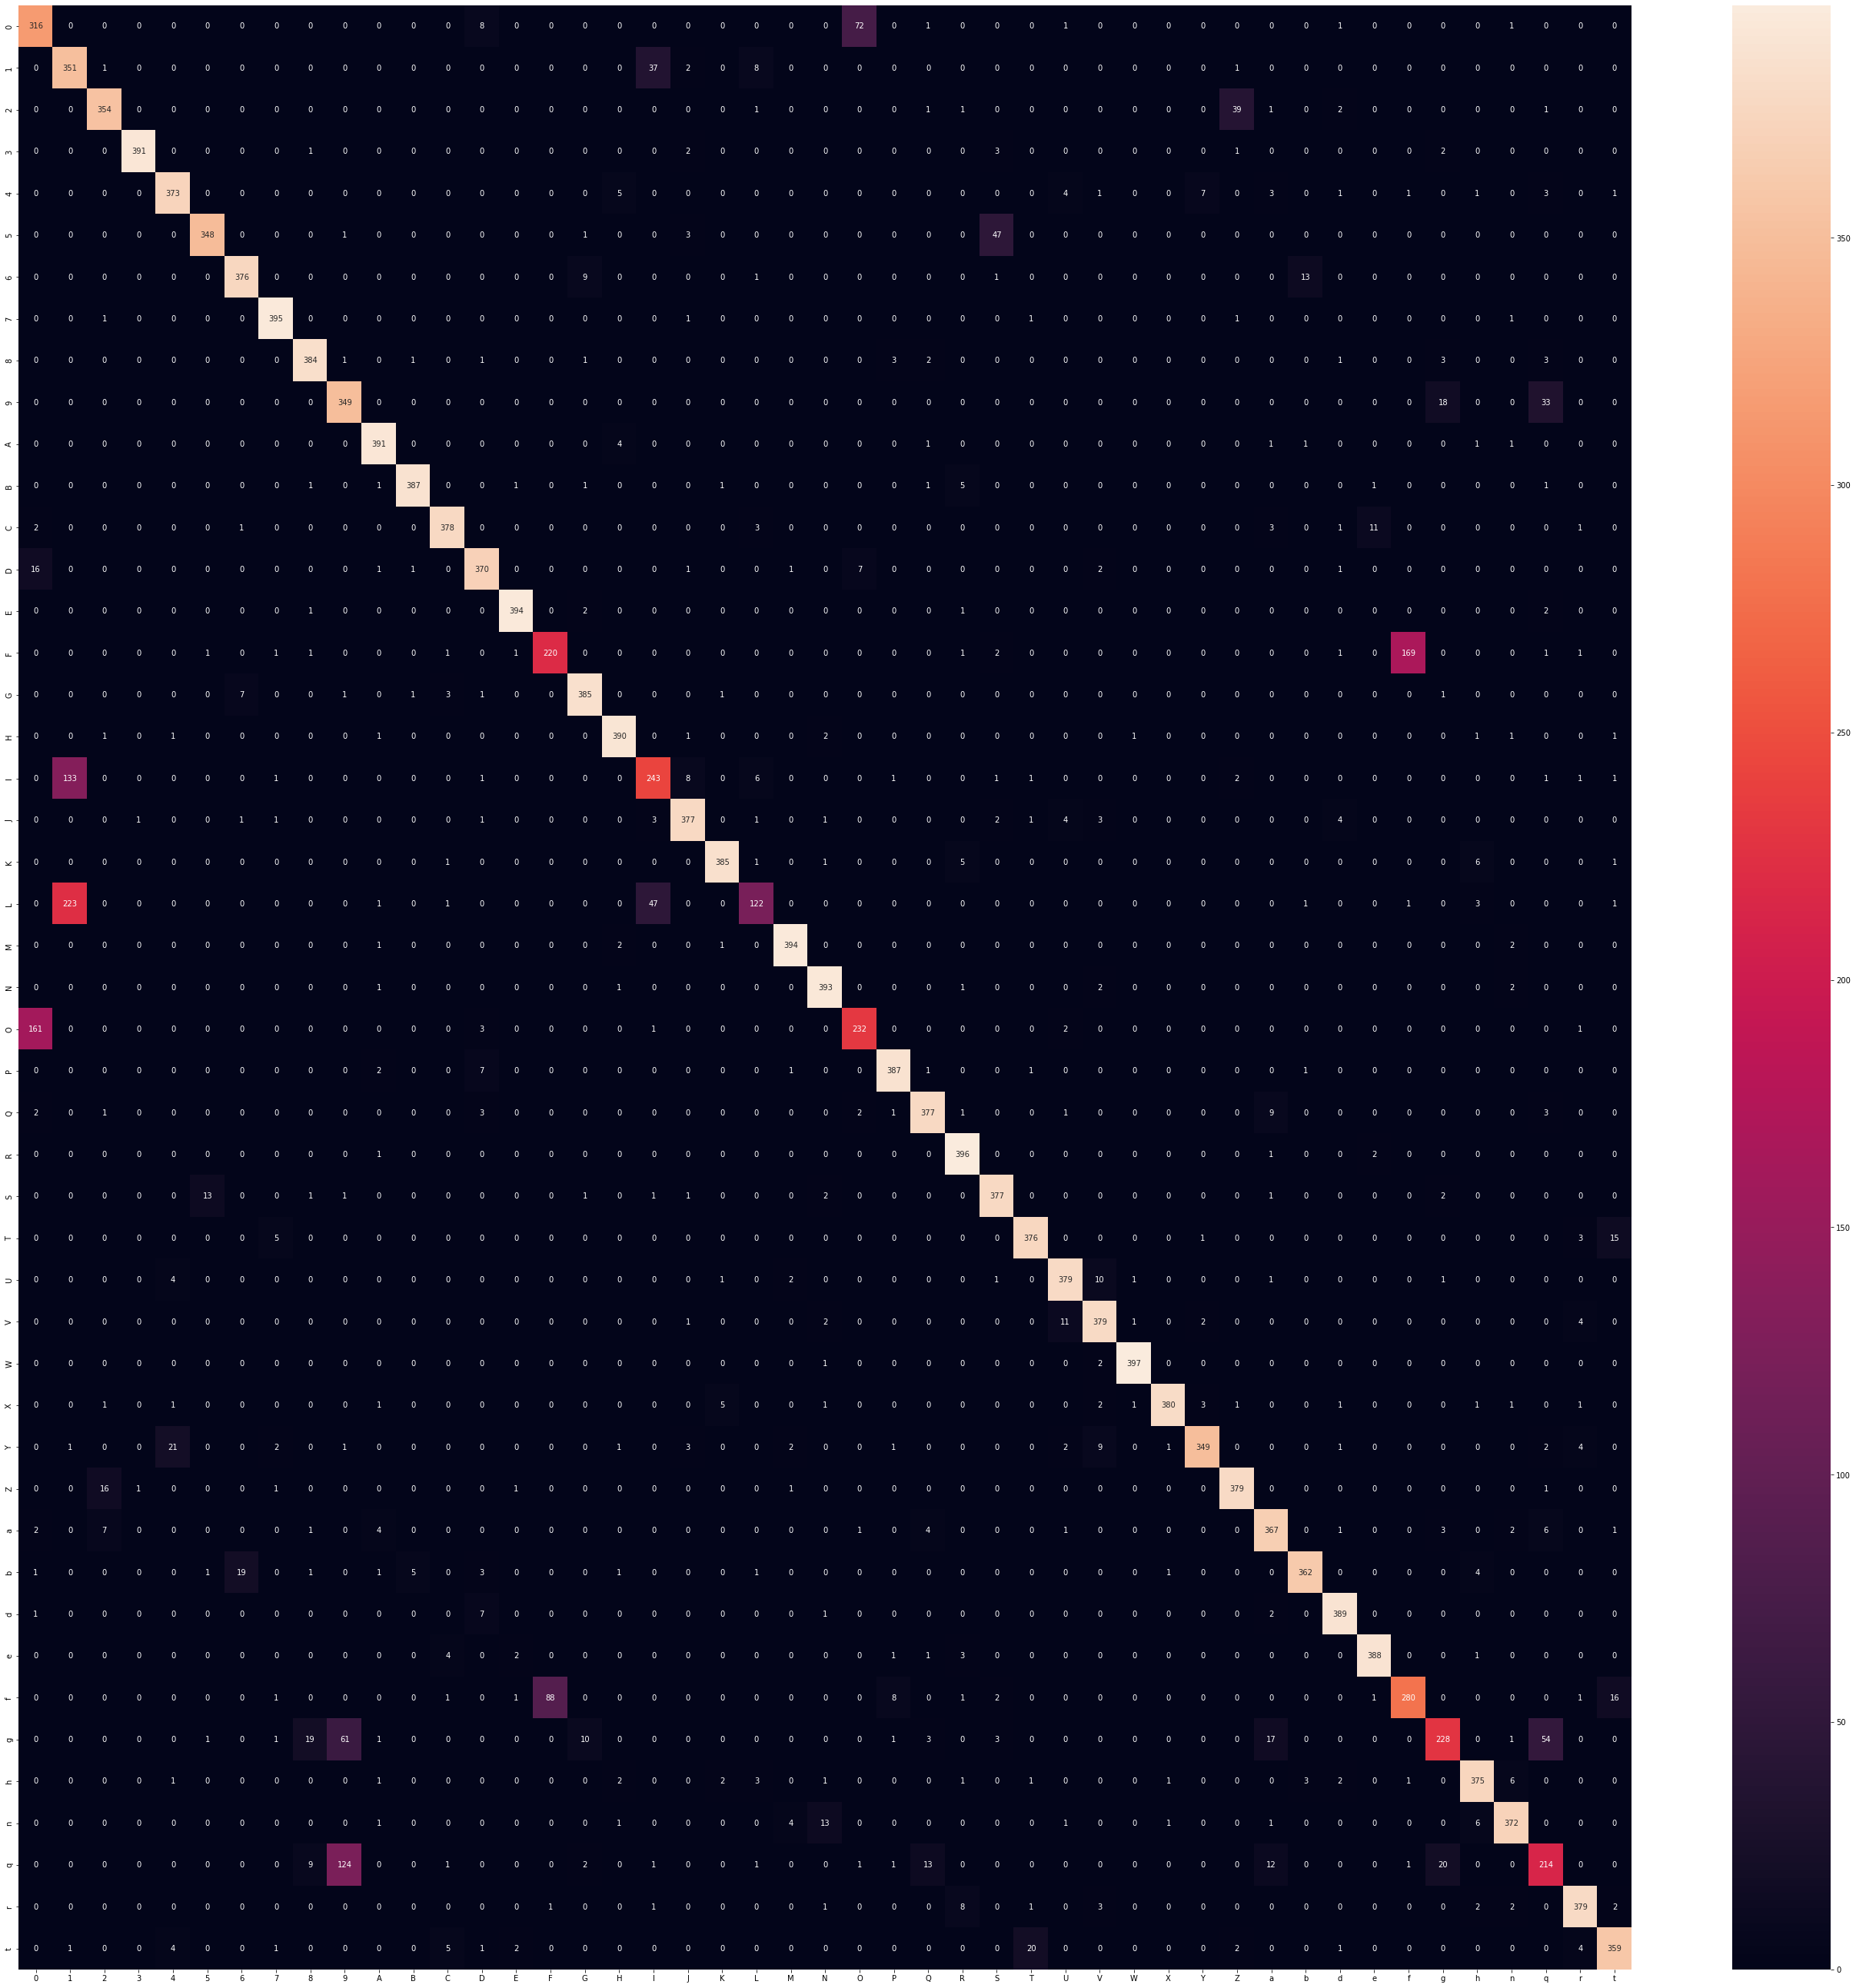

In [66]:
import seaborn as sn

#We use rounded_labels to convert them to Single Digits from One-Hot Encoding
rounded_labels=np.argmax(test_labels, axis=1)

matrix = confusion_matrix(rounded_labels, np.argmax(model.predict(X_test[:]),axis=1))

df_cm = pd.DataFrame(matrix, index = [i for i in class_names],
                  columns = [i for i in class_names],
                  dtype=np.int)

plt.figure(figsize = (47,47))
sn.heatmap(df_cm, annot=True,fmt='g')


# **Testing our own Images**

In [52]:
def predict(image):
  img = resize_image(image)
  img = img[:,:,0]
  img = img.reshape((1,28,28))
  
  prediction = model.predict(img[:])
  return class_names[np.argmax(prediction)]


# Resize image function without affecting quality of character
# Adding black color pixels peripherally of the character so we receive an image with size 28 * 28

def resize_image(img, size=(28,28)):

    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

def printImage(image):
  print("The text inserted is: ")
  img = cv2.imread(image)
  plt.imshow(img)
  plt.show()

In [ ]:
def printPossibleWord(prediction):

   
    #import dictionary (JSON file) as a list
    with open('words_dictionary.json') as f:
      words_dict = json.load(f)


    # find the closest match word with our input
    matches = get_close_matches(prediction, words_dict, n=3, cutoff=0.6)
      

    #find the match with most similar characters with the input  
    max_value = 0
    similar_character_counter = zerolistmaker(len(matches))
    
    for i in range(len(matches)):
      if len(matches[i]) != len(prediction):
          continue
      
      for j in range(len(prediction)):
        if matches[i][j] == prediction[j]:
          similar_character_counter[i] += 1
    
    if(similar_character_counter):
     max_value = max(similar_character_counter)
    max_value_list = [i for i, j in enumerate(similar_character_counter) if j == max_value]
    
    # Print the possible word from the dictionary
    print("Closest matches from the dictionary:")
    for i in max_value_list:
      print(matches[i].capitalize())
    
    print("\n")
    similar_character_counter = []


def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros


# **Input custom words**

The text inserted is: 


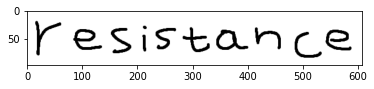

Model's Prediction: Reslstance
Closest matches from the dictionary:
Resistance


The text inserted is: 


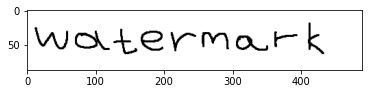

Model's Prediction: Watermark
Closest matches from the dictionary:
Watermark


The text inserted is: 


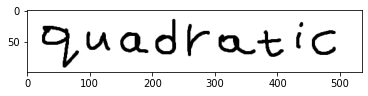

Model's Prediction: Guadratlc
Closest matches from the dictionary:
Quadratic


The text inserted is: 


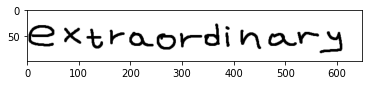

Model's Prediction: Extraordlnary
Closest matches from the dictionary:
Extraordinary




In [ ]:

def make_predictions(test_image_path):
  chars = segmented_image(image_path=test_image_path)

  preds=model.predict(chars) 
  preds=np.argmax(preds,axis=1)

  predicted_phrase= str()
  for i in preds:
    n=class_names[i]
    p=str(n)
    predicted_phrase=predicted_phrase+n
  

  print("Model's Prediction:", predicted_phrase.capitalize())
  printPossibleWord(predicted_phrase.capitalize())


test_1 = '/content/1.png'
printImage(test_1)
make_predictions(test_1)

test_2 = '/content/2.png'
printImage(test_2)
make_predictions(test_2)

test_3 = '/content/3.png'
printImage(test_3)
make_predictions(test_3)

test_4 = '/content/4.png'
printImage(test_4)
make_predictions(test_4)



# **Input number image**

The text inserted is: 


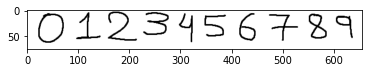

Model's Prediction: 012345g789


In [63]:
def make_predictions(test_image_path):
  chars = segmented_image(image_path=test_image_path)

  preds=model.predict(chars) 
  preds=np.argmax(preds,axis=1)

  predicted_phrase= str()
  for i in preds:
    n=class_names[i]
    p=str(n)
    predicted_phrase=predicted_phrase+n
  

  print("Model's Prediction:", predicted_phrase.capitalize())


test_1 = '/content/1.png'
printImage(test_1)
make_predictions(test_1)
